In [ ]:
# activations, gradients, batchnorm

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [7]:
len(words)

32033

In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?


def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
# MLP
n_embd = 10 # dimensionality of a single char embedding
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # look-up table for char embeddings ix:emb
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [15]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

  # forward pass
  emb = C[Xb] # (batch_size, context_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activations
  h = torch.tanh(hpreact) # hidden layer - after actiovations
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 27.8817
   1000/  20000: 4.1899
   2000/  20000: 3.0992
   3000/  20000: 2.9468
   4000/  20000: 2.2726
   5000/  20000: 2.4072
   6000/  20000: 2.4195
   7000/  20000: 2.8040
   8000/  20000: 2.5150
   9000/  20000: 2.5398
  10000/  20000: 2.9415
  11000/  20000: 1.9093
  12000/  20000: 2.1238
  13000/  20000: 2.1738
  14000/  20000: 2.8303
  15000/  20000: 2.2554
  16000/  20000: 2.4044
  17000/  20000: 2.3875
  18000/  20000: 2.1968
  19000/  20000: 2.2890


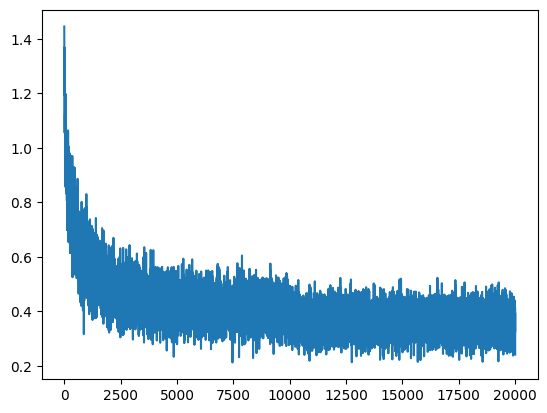

In [16]:
plt.plot(lossi)

In [18]:
# train and val loss
@torch.no_grad() # decorator to diable gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_emb)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.308692455291748
val 2.3186745643615723


In [21]:
# sample from the model

g = torch.Generator().manual_seed(2132454565)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

aniaan.
winah.
kanayle.
jomitdanien.
kaym.
haj.
naweretellanyanen.
wah.
reckotri.
jasebs.
sen.
nay.
ketoston.
ses.
ama.
brie.
ane.
sen.
esdoldan.
nia.
